In [2]:
from nd2reader import ND2Reader
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import os
import imageio
import pandas as pd
from scipy import signal
import scipy as sp
from scipy import stats as st
from skimage import filters, color, morphology
from skimage.segmentation import watershed, mark_boundaries
from scipy.ndimage.morphology import distance_transform_edt
from skimage.feature import peak_local_max
from scipy.ndimage import label
import cv2
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF 
from scipy.ndimage import label
from skimage.filters import threshold_otsu
import numpy as np

C:\Users\raymo\AppData\Local\Temp\ipykernel_16708\3774340177.py:13: DeprecationWarning: Please use `distance_transform_edt` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import distance_transform_edt


In [3]:
#Ill make it a function
def boxcar(shape,array):
    #boxcar time
    kernel = np.ones([shape,shape]) / shape**2
    #convolve one layer and then make that layer all of the layers
    dim=len(array.shape)
    if dim==3:
        r=np.array(array[:,:,0])
        g=np.array(array[:,:,1])
        b=np.array(array[:,:,2])
        finalR=sp.ndimage.convolve(r,kernel)
        finalG=sp.ndimage.convolve(g,kernel)
        finalB=sp.ndimage.convolve(b,kernel)
        temp=np.array(array)
        temp[:,:,0]=finalR
        temp[:,:,1]=finalG
        temp[:,:,2]=finalB
        return temp
    else:
        data=np.array(array)
        final=sp.ndimage.convolve(data,kernel)
        #now make new array with the convoled data
        return final
def local_binary(arr,box_size,const,show=False):
    #local binary
    threshold = boxcar(box_size,arr) + const
    fin=np.where(arr < threshold, 0, 255)
    if show:
        plt.imshow(fin,cmap=plt.cm.gray)
    return fin
def blur_sub(arr,box_size,show=False):
    #blur and subtract background
    b=boxcar(box_size,arr)
    fin=sub_img(arr,b)
    if show:
        plt.imshow(fin,cmap=plt.cm.gray)
    return fin
def sub_img(arr1,arr2):
    #subracting images and dealing with flips
    fir=np.array(arr1,dtype=float)
    sec=np.array(arr2,dtype=float)
    fin=fir-sec
    fin=np.array(np.where(fin<0,0,fin)*(255/fin.max()),dtype=np.uint8)
    return fin
def otsu_binary(arr):
    if len(arr.shape)==2:
        scaled=(arr/arr.max())*255 #needed for filter
        ttemp=np.stack([scaled,scaled,scaled],axis=2)
        t=color.rgb2gray(ttemp)
        thres=filters.threshold_otsu(t)
        t2 = np.where(t > thres,1,0)
        return t2
    else:
        scaled=(arr/arr.max())*255 #needed for filter
        t=color.rgb2gray(scaled)
        thres=filters.threshold_otsu(t)
        t2 = np.where(t > thres,1,0)
        t3=np.stack([t2,t2,t2],axis=2)
        return t3

def get_connected_components(image):
    # Label the connected components
    labeled_array, num_features = label(image)
    
    # Extract the connected components
    components = []
    for i in range(1, num_features + 1):
        component = (labeled_array == i).astype(int)
        components.append(component)
    
    return labeled_array,components
def get_masked_region(img, mask):
    """
    Obtain the image region corresponding to the mask.
    """
    masked = img * mask
    return masked[mask > 0]

In [4]:
files_to_do=[]
for file in os.listdir("lab_data_images/7_27_21"):
    files_to_do.append(file[:-4])

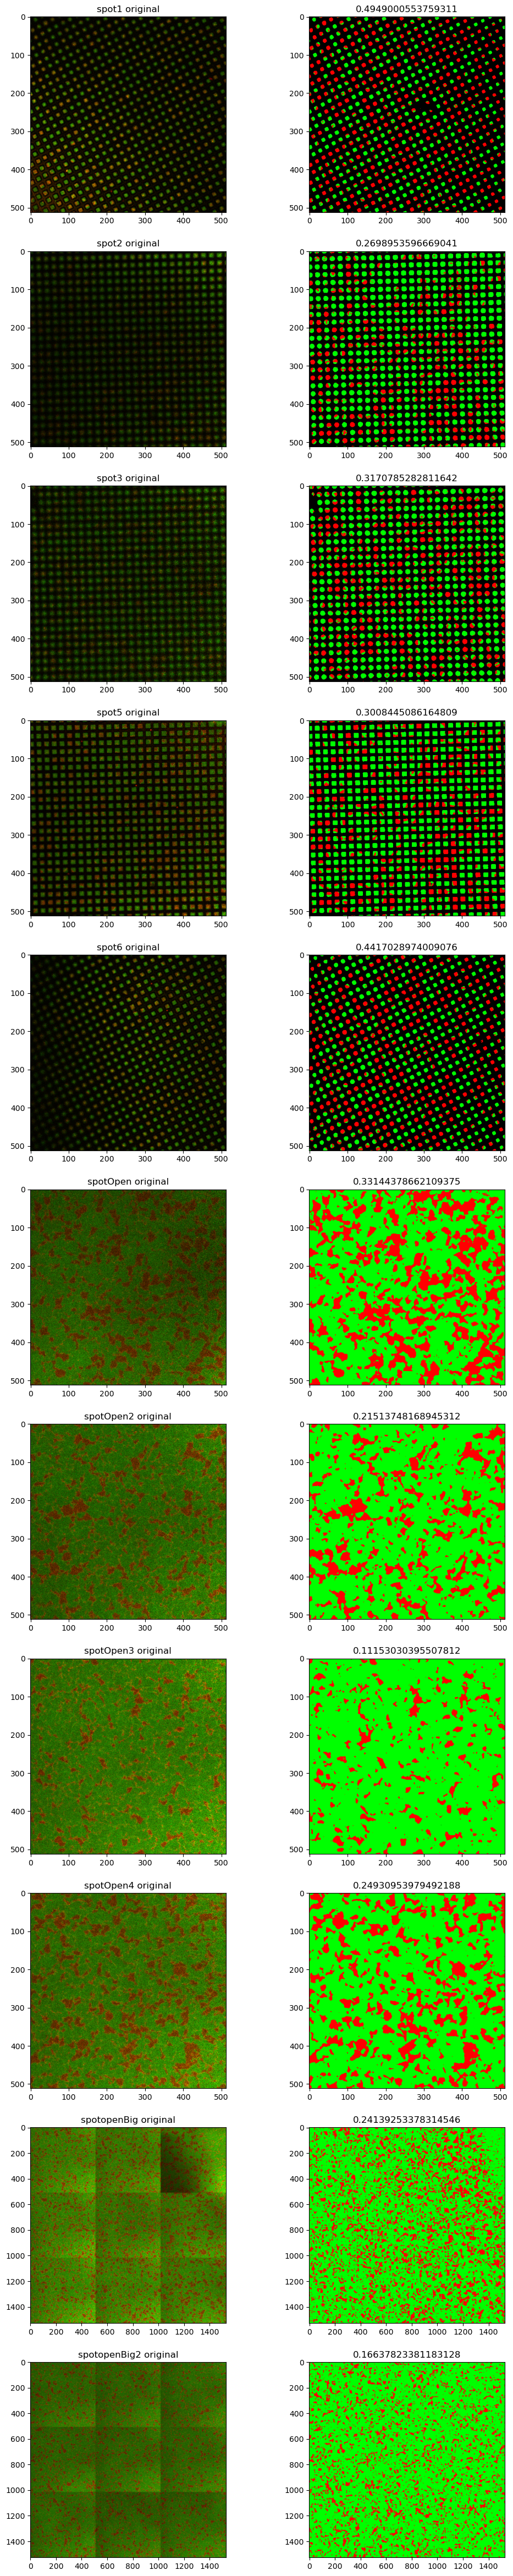

In [17]:
#with blur
fin = {}
box_size=4
fig, axs = plt.subplots(11, 2, figsize=(12, 60))  # Setting up a 5x2 grid of subplots, adjust figsize as needed
axs = axs.flatten()  # Flatten the axis array for easier indexing
plot_idx = 0  # Initialize plot index
for folder in os.listdir("lab_data"):
    path_get=f"lab_data/{folder}/"
    path_put=f"lab_data_images/{folder}/"
    for file in os.listdir(f"lab_data/{folder}"):
        if file[:-4] not in files_to_do:
            continue
        with ND2Reader(path_get + file) as images:
            # Determine the last z-level
            num_z_levels = images.sizes['z'] if 'z' in images.sizes else 1
            last_z_level = num_z_levels - 1
            if "open" not in file.lower():
                # Extract the red and green channels using get_frame_2D
                r = images.get_frame_2D(c=1, z=last_z_level)
                g = images.get_frame_2D(c=0, z=last_z_level)
                t = images.get_frame_2D(c=2, z=last_z_level)
                # Normalize and handle NaN values
                r = np.nan_to_num(r)
                g = np.nan_to_num(g)
                dataO=np.zeros((g.shape[0],g.shape[1],3))
                dataO[:,:,0]=(r/r.max())
                dataO[:,:,1]=(g/g.max())
                data=dataO.copy()
                #get blur
                g=boxcar(box_size,g)
                r=boxcar(box_size,r)
                #got the data
                rf=np.where(r>g,255,0)
                gf=np.where(g>r,255,0)
                #set the local binary in data before manipulation
                data[:,:,0]=rf
                data[:,:,1]=gf
                #now we use T channel to get mask
                t2 = otsu_binary(t)
                t3=np.stack([t2,t2,t2],axis=2)
                data=data*t3 #now mask the binerized data
                data=np.rint(data/data.max()) #bring it back to 0's and 1's as we already masked/scaled
                fin[file[:-4]]=data[:,:,0].sum()/(t2.sum())
            else:
                # Extract the red and green channels using get_frame_2D
                r = images.get_frame_2D(c=1, z=last_z_level)
                g = images.get_frame_2D(c=0, z=last_z_level)
                # Normalize and handle NaN values
                r = np.nan_to_num(r)
                g = np.nan_to_num(g)
                dataO=np.zeros((g.shape[0],g.shape[1],3))
                dataO[:,:,0]=(r/r.max())
                dataO[:,:,1]=(g/g.max())
                data=dataO.copy()
                #get blur
                g=boxcar(box_size,g)
                r=boxcar(box_size,r)
                #got the data
                rf=np.where(r>g,255,0)
                gf=np.where(g>r,255,0)
                #set the local binary in data before manipulation
                data[:,:,0]=rf
                data[:,:,1]=gf
                #now we use T channel to get mask
                data=np.rint(data/data.max()) #bring it back to 0's and 1's as we already masked/scaled
                fin[file[:-4]]=data[:,:,0].sum()/(data.shape[0]*data.shape[1])
            if 'spotopen2' in file.lower():
                data_final=data
            # Plotting
            if plot_idx < 22:  # Ensure we don't try to plot more than 10 images
                axs[plot_idx].imshow(dataO)
                axs[plot_idx].set_title(file[:-4]+' original')
                plot_idx += 1  # Increment index

                axs[plot_idx].imshow(data)
                axs[plot_idx].set_title(f"{fin[file[:-4]]}")
                plot_idx += 1  # Increment index
            else:
                print(f"Skipping plotting for {file} as plot grid is full.")
plt.savefig("Old_data.png")


In [21]:
fin

{'spot1': 0.4949000553759311,
 'spot2': 0.2698953596669041,
 'spot3': 0.3170785282811642,
 'spot5': 0.3008445086164809,
 'spot6': 0.4417028974009076,
 'spotOpen': 0.33144378662109375,
 'spotOpen2': 0.21513748168945312,
 'spotOpen3': 0.11153030395507812,
 'spotOpen4': 0.24930953979492188,
 'spotopenBig': 0.24139253378314546,
 'spotopenBig2': 0.16637823381183128}

In [23]:
import numpy as np
from scipy import stats

# Assume data1 and data2 are your data sets
small_grid = np.array(list(fin.values())[0:5])
open_spots = np.array(list(fin.values())[5:])
large_grid=np.array([0.1462814 , 0.03514857, 0.2359604 , 0.22615325, 0.17763404])
# Perform the t-test assuming equal variance
var=True
t_stat, p_value = stats.ttest_ind(small_grid, open_spots, equal_var=var)
# Output the results
print(f'P-value for small grid and open space: {p_value}')
#now for open and large grids
t_stat, p_value = stats.ttest_ind(open_spots, large_grid, equal_var=var)
print(f'P-value for large grid and open: {p_value}')
#now for small and large grid
t_stat, p_value = stats.ttest_ind(large_grid, small_grid, equal_var=var)
print(f'P-value for large grid and small grid: {p_value}')

P-value for small grid and open space: 0.020828782258794983
P-value for large grid and open: 0.2735853305650131
P-value for large grid and small grid: 0.00765199152741129


In [25]:
std=np.std(open_spots)
mean=np.mean(open_spots)
# Output the results
print(f'Std for open space: {std} with mean {mean}')
#now for open and large grids
std=np.std(large_grid)
mean=np.mean(large_grid)
# Output the results
print(f'Std for large grid: {std} with mean {mean}')
#now for small and large grid
std=np.std(small_grid)
mean=np.mean(small_grid)
# Output the results
print(f'Std for small grid: {std} with mean {mean}')

Std for open space: 0.06879579329568611 with mean 0.21919864660925395
Std for large grid: 0.07230985427012543 with mean 0.16423553200000002
Std for small grid: 0.08742377139919634 with mean 0.3648842698682776
